# DS 7333 - Quantifying the World
## Case Study #2 - Modeling Runners' Times in the Cherry Blossom Race

Sterling Beason, Sean Kennedy, Emil Ramos

## Introduction

Every year, the Credit Union Cherry Blossom Ten Mile Run takes place in Washington, D.C. and brings together credit unions from across the country with a a goal of fund raising for helping children. The proceeds from the race helps support Children’s Hospitals that belong to the Children's Miracle Network Hospitals, a non-profit international organization that helps to treat millions of children across the U.S. and Canada. The Ten Mile Run has grown in popularity and grown to as many as 17,000 runners with ages rangin from 9 to 89 participated.

In this case study, we are interested in understanding how people's physical performance changes as they age. We will use the information the race organizers collect about each runner which they publish individual-level data on their website. Some of the data includes runners' times and can provide us with insights to our question regarding performance and age.

## Objective

Web scrape cherryblossom.org race results to seek out data to bring insight for female runners from 1999 to 2012 and explore the data.

In [1]:
import os
import re
import pandas as pd
import requests as r
from bs4 import BeautifulSoup
import bleach
import matplotlib.pyplot as plt

### Download Copies of Pages

In [2]:
HTML_DIR = 'HTML'
URLS = [
    'http://www.cherryblossom.org/results/1999/cb99f.html',
    'http://cherryblossom.org/results/2000/Cb003f.htm',
    'http://www.cherryblossom.org/results/2001/oof_f.html',
    'http://www.cherryblossom.org/results/2002/ooff.htm',
    'http://www.cherryblossom.org/results/2003/CB03-F.HTM',
    'http://www.cherryblossom.org/results/2004/womennet.htm',
    'http://www.cherryblossom.org/results/2005/womennet.htm',
    'http://www.cherryblossom.org/results/2006/womennet.htm',
    'http://www.cherryblossom.org/results/2007/women.htm',
    'http://www.cherryblossom.org/results/2008/women.htm',
    'http://www.cherryblossom.org/results/2009/09cucb-F.htm',
    'http://www.cherryblossom.org/results/2010/2010cucb10m-f.htm',
    'http://cherryblossom.org/results/2011/2011cucb10m-f.htm',
    'http://cherryblossom.org/results/2012/2012cucb10m-f.htm',
]

In [ ]:
# download copies of HTML (reduces spamming server while developing)
for index, url in enumerate(URLS):
    # query url
    resp = r.get(url)
    html = resp.text
    
    # save copy (mapped by index of url)
    with open(os.path.join(os.path.abspath(''), HTML_DIR, f"{index}.html"), 'w') as file:
        file.write(html)
        file.close()

### Read HTML into Memory

In [3]:
pages = []

# read html copies into memory
for index, url in enumerate(URLS):
    with open(os.path.join(os.path.abspath(''), HTML_DIR, f"{index}.html"), 'r') as file:
        html = file.read()
        pages.append(html)

### Extract Relevant Data

**Team,** here is how I tackled this:


* Iterate through each page's HTML text
* Stripped all tags except "pre" with 'bleach' (this fixed HTML errors bs4 couldn't handle)
* Extract text contents of "pre" tag
* Split text by lines "\n"
* By line, seperated values between variable length of spaces (**NOTE:** the regular expression I made doesn't yet handle 3 part names. These will have an "N/A" for age until fixed)
* Due to missing values on some pages, I loop through the etracted values to find the most likely string to be a name. Then I assume the next value is an age. Age is checked to be a digit, else replaced with "N/A"
* At this stage, there are a couple of generic error messages I used to track empty rows or no values matching a name. Those rows are skipped, but so far that looks okay.
* Each years rows are added to a single list. [[year, place, name, age]] (this can be changed to a dictionary by years if that makes more sense.
* Data into a pandas DataFrame with columns. df

In [4]:
data = [] # will hold rows of all data in all years

for p_index, page in enumerate(pages):
    
    # determine year by page index
    year = range(1999, 2013)[p_index]
    
    print(f"Processing year: {year}")
    print("==========================")

    html = bleach.clean(page, tags=['pre'], strip=True) # remove all tags except <pre> (fixed broken html)
    soup = BeautifulSoup(html)
    pre = soup.find("pre")
    
    # get text from pre element > remove all periods > split new lines "\n"
    lines = pre.get_text().replace('.', '').split("\n")

    # remove lines before "===="
    for index, line in enumerate(lines):
        if re.match("\W*=+", line):
            # start list line found
            lines = lines[index:] # remove lines before "==="
            break

    rows_unmapped = [re.findall("\W*([a-z'-]+ {1}[a-z'-]+ {1}[a-z'-]+ {1}[a-z'-]+|[a-z'-]+ {1}[a-z'-]+ {1}[a-z'-]+|[a-z'-]+ {1}[a-z'-]+|[a-z0-9/:'-]*)\W+?", line, re.I) for line in lines]

    # "\W*([a-z'-]+ {1}[a-z'-]+|[a-z0-9/:'-]*)\W+?" <- doesn't allow 3 part names

    # finals
    rows = [] # [[name, age]] ordered by PLACE

    # find name index for each line
    for r_i, row in enumerate(rows_unmapped):
        name_index = None

        # handle empty rows?
        if len(row) < 2:
            print(f"empty row? ({r_i})")
            print(f" - row value: {row}")
            continue # skip this

        for v_i, val in enumerate(row):
            if re.match("[a-z '-]{2,}", val, re.I):
                # found name val
                name_index = v_i
                break

        # handle unfound name
        if name_index == None:
            print(f"error for {r_i}")
            name_index = 2 #  temp remove/refactor error handling

        # check that next col from name is actually a digit, else NA
        age = row[name_index + 1]
        if age.isdigit() == False:
            age = "N/A"

        rows.append([year, row[0], row[name_index], age]) # [year, place, name, age]
    
    # add this years rows to overall data list
    data = data + rows

Processing year: 1999
empty row? (0)
 - row value: ['']
empty row? (2357)
 - row value: []
Processing year: 2000
empty row? (0)
 - row value: ['']
empty row? (2168)
 - row value: []
Processing year: 2001
empty row? (0)
 - row value: ['']
empty row? (1)
 - row value: ['']
Processing year: 2002
empty row? (0)
 - row value: ['']
empty row? (3336)
 - row value: []
Processing year: 2003
empty row? (0)
 - row value: ['']
empty row? (3544)
 - row value: ['Under USATF Age-Group']
empty row? (3545)
 - row value: []
Processing year: 2004
empty row? (0)
 - row value: ['']
empty row? (3901)
 - row value: ['Under USATF Age-Group']
Processing year: 2005
empty row? (0)
 - row value: ['']
empty row? (4334)
 - row value: ['']
empty row? (4336)
 - row value: ['Under USATF Age-Group']
Processing year: 2006
empty row? (0)
 - row value: ['']
empty row? (5437)
 - row value: ['Under USATF Age-Group']
empty row? (5438)
 - row value: []
Processing year: 2007
empty row? (0)
 - row value: ['']
empty row? (5692)


### Explore Data

In [5]:
df = pd.DataFrame(data, columns=['year', 'place', 'name', 'age'])
df['age'] = pd.to_numeric(df['age'], errors='coerce')

df

,year,place,name,age
0,1999,1,Jane Omoro,26.0
1,1999,2,Jane Ngotho,29.0
2,1999,3,Lidiya Grigoryeva,NaN
3,1999,4,Eunice Sagero,20.0
4,1999,5,Alla Zhilyayeva,29.0
...,...,...,...,...
76064,2012,9726,Khristina Nava,40.0
76065,2012,9727,Geneva Dixon,31.0
76066,2012,9728,Veronica Eligan,55.0
76067,2012,9729,Denise Bobba,40.0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76069 entries, 0 to 76068
Data columns (total 4 columns):
year     76069 non-null int64
place    76069 non-null object
name     76069 non-null object
age      76018 non-null float64
dtypes: float64(1), int64(1), object(2)
memory usage: 2.3+ MB


In [7]:
# Explore NAs
print(df['age'].isna().sum())

df.loc[df['age'].isnull()]

51


,year,place,name,age
2,1999,3,Lidiya Grigoryeva,NaN
7,1999,8,Gladys Asiba,NaN
16,1999,17,Connie Buckwalter,NaN
2174,1999,2175,Ann Reid,NaN
4522,2000,Under USATF OPEN guideline,Under USATF OPEN guideline,NaN
6954,2001,2432,Maria,NaN
7495,2001,Under USATF OPEN guideline,Under USATF OPEN guideline,NaN
7765,2002,270,Unknown RUNNER,NaN
8776,2002,1281,Melissa AKEY,NaN
9679,2002,2184,Yvonne BONNER,NaN


## Question 10  

**We have seen that the 1999 runners were typically older than the 2012 runners. Compare the age distribution of the [female] runners across all 14 years of the races. Use quantile–quantile plots, boxplots, and density curves to make your comparisons. How do the distributions change over the years? Was it a gradual change?**

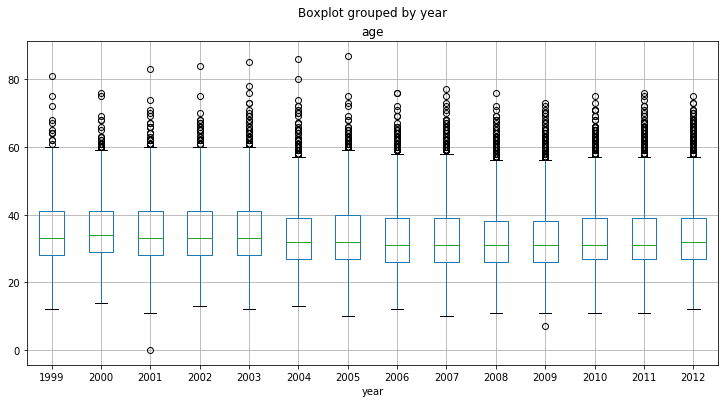

In [12]:
# Boxplot: age distribution by year
df.boxplot(by='year', column = 'age', figsize=(12,6))